In [10]:
!pip install konlpy

In [38]:
# 필요한 모듈 임포트
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
import re

# 데이터 전처리

In [1]:
comments_df = pd.read_csv('./data/japan_youtube_comments.csv')
display(comments_df.head(3))

,keywords,comments,years,trans_comments
0,韓国旅行,wifiは韓国の日本語サイトで予約したら半額で借りれる,2024,와이파이를 한국 일본어 사이트에서 예약하면 반값에 대여할 수 있다.
1,韓国旅行,辛くないが辛い辛くないの食べたい時はどうしたらいいんだ,2024,맵지 않은 매운맛을 먹고 싶을 때는 어떻게 하면 좋을까?
2,韓国旅行,韓国も随分変わりましたな昔は英語は日本より通じなくて手書きの漢字の方が中年の方との会話には通...,2024,"한국도 많이 변했네요, 예전에는 영어가 일본보다 통하지 않아 손글씨로 쓴 한자가 중..."


In [9]:
# 번역이 되지 않은 행 삭제
comments_df = comments_df.drop(comments_df[comments_df['trans_comments'] == 'error'].index, axis=0)

In [11]:
# 전처리(1) : 이모티콘, 특수문자 제거

import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

okt = Okt()

# 이모티콘, 특수문자 제거
def preprocess(text):
    # 이모티콘, 유니코드 범위 및 특수 문자를 제거하는 정규식 (숫자는 제외)
    emoji_pattern = re.compile(
        r"["
        r"\U0001F600-\U0001F64F"  # 이모티콘 범위 (유니코드)
        r"\U0001F300-\U0001F5FF"  # 기호 및 아이콘
        r"\U0001F680-\U0001F6FF"  # 운송 및 기계 관련 유니코드
        r"\U0001F700-\U0001F77F"  # 기타 유니코드 기호
        r"\U0001F780-\U0001F7FF"  # 추가 유니코드 기호
        r"\U0001F800-\U0001F8FF"  # 유니코드 기술 문자
        r"\U0001F900-\U0001F9FF"  # 제스처와 감정 관련 이모티콘
        r"\U0001FA00-\U0001FA6F"  # 이모티콘 확장
        r"\U0001FB00-\U0001FBFF"  # 추가 확장 이모티콘
        r"\u2600-\u26FF"          # 기호 및 도형 (예: ♠, ♣)
        r"\u2700-\u27BF"          # 기타 기호 (예: ✨, ✋)
        r"]+",
        flags=re.UNICODE
    )

    # 정규식을 이용해 매칭되는 문자 제거
    return emoji_pattern.sub(r'', str(text))

# 모든 텍스트에 대해 전처리 적용
comments_df['trans_comments_re'] = comments_df['trans_comments'].apply(preprocess)

display(comments_df.head(3))

,keywords,comments,years,trans_comments,trans_comments_re
0,韓国旅行,wifiは韓国の日本語サイトで予約したら半額で借りれる,2024,와이파이를 한국 일본어 사이트에서 예약하면 반값에 대여할 수 있다.,와이파이를 한국 일본어 사이트에서 예약하면 반값에 대여할 수 있다.
1,韓国旅行,辛くないが辛い辛くないの食べたい時はどうしたらいいんだ,2024,맵지 않은 매운맛을 먹고 싶을 때는 어떻게 하면 좋을까?,맵지 않은 매운맛을 먹고 싶을 때는 어떻게 하면 좋을까?
2,韓国旅行,韓国も随分変わりましたな昔は英語は日本より通じなくて手書きの漢字の方が中年の方との会話には通...,2024,"한국도 많이 변했네요, 예전에는 영어가 일본보다 통하지 않아 손글씨로 쓴 한자가 중...","한국도 많이 변했네요, 예전에는 영어가 일본보다 통하지 않아 손글씨로 쓴 한자가 중..."


In [58]:
# 전처리(2) : 유사 단어 치환, 명사, 용언 추출, 불용어 처리

# 특정 동사의 변형을 원형으로 통합하는 함수
def normalize_verb(word):
    # 유사 단어 치환
    replace_dict = {
        "서울특별시": "서울",
        "수도" : "서울",
        "부산광역시": "부산",
        "경기도" : "경기",
        "제주도": "제주",
        "강원도" : "강원",
        "인천광역시" : "인천"
        # 필요한 만큼 추가
    }
    return replace_dict.get(word, word)  # 해당 변형이 없으면 원래 단어 반환

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if tag in ['Noun', 'Verb', 'Adjective']:  # 명사, 동사, 형용사, 부사만 유지
            word = normalize_verb(word)  # 변형된 용언을 원형으로 통합

            # 명사와 부사에는 '다'를 붙이지 않음
            if tag in ['Verb', 'Adjective'] and not word.endswith('다'):
                word += '다'
            elif tag == 'Noun' and len(word) == 1:
                continue

            result.append(word)

    return result

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다", "갈다",
              "일본", "일본인", "히카킨", "모두", "나다", "유카타", "나라", "보고", "시온", "영상", "동영상", "한국인", "항상", "기모노" ,"호진", "신사",
              "다음", "처음", "코피", "니코", "돼다", "데카", "하루", "에밀", "다카", "호코", "야마",
              "마츠리", "기획", "다른", "기분", "지금", "카시", "어떻다", "아야", "가지", "데보", "이키", "다른", "역시", "가마",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드"]  # 커스텀 불용어 리스트

In [59]:
# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출

word_df_of_keyword = {}

for keyword in comments_df['keywords'].unique():
    all_words = []
    for text in comments_df.loc[comments_df['keywords'] == keyword, 'trans_comments_re']:
        all_words.extend(preprocess_text(text))

        # 단어 빈도 계산
        word_counts = Counter(all_words)
        
        # 데이터프레임으로 변환
        df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])
        df_word = df_word[~df_word['word'].isin(stop_words)]
        
        # 상위 50개 단어를 빈도순으로 정렬하여 출력
        word_df_of_keyword[keyword] = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)



In [60]:
# print(comments_df['keywords'].unique()) # '韓国旅行' '韓国旅行 韓国のお祭り'
display(word_df_of_keyword['韓国旅行'].head(100))
display(word_df_of_keyword['韓国旅行 韓国のお祭り'].head(100))

,word,freq
0,좋다,735
1,사람,457
2,재미있다,267
3,즐겁다,246
4,귀엽다,236
...,...,...
95,정보,34
96,내다,34
97,예고편,34
98,마음,33


,word,freq
0,축제,698
1,좋다,426
2,자다,302
3,사람,268
4,귀엽다,249
...,...,...
95,솔직하다,28
96,어리다,28
97,계속,27
98,우리,27


韓国旅行


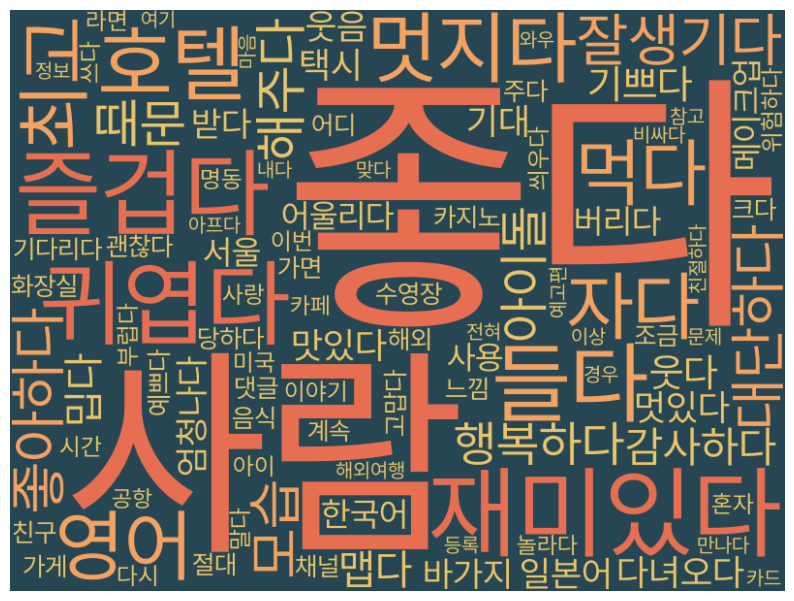

韓国旅行 韓国のお祭り


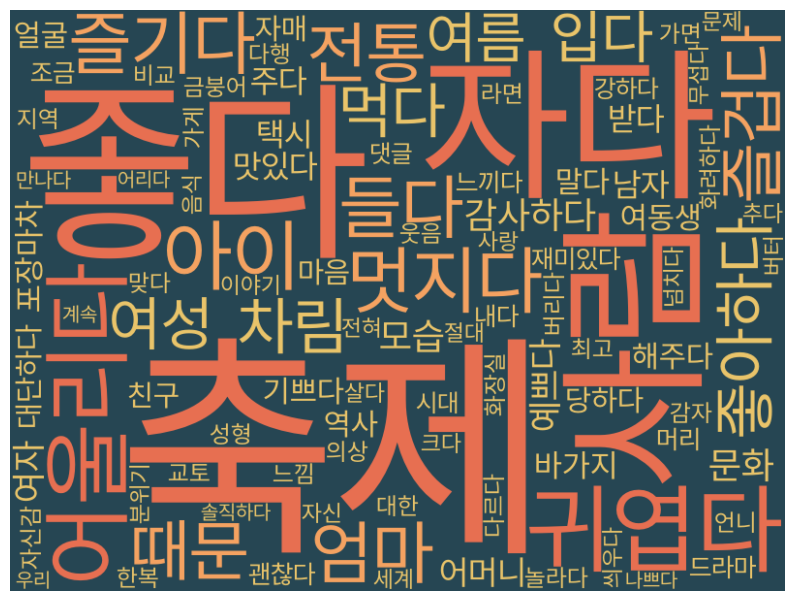

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로
font_path = 'C:\\Users\\eighttwofive\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Pretendard-Regular.otf'

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = top_words.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

for keyword in comments_df['keywords'].unique():

    print(keyword)
    
    # 상위 100개 데이터 사용
    top_words = word_df_of_keyword[keyword].head(100)
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,          # 한글 폰트 경로 설정
        background_color='#264653',  # 배경색
        width=800,
        height=600,
        min_font_size=4,             # 최소 글자 크기
        color_func=color_func        # 색상 함수
    ).generate_from_frequencies(dict(top_words.values))
    
    # 워드클라우드 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 워드클라우드 분석 정리

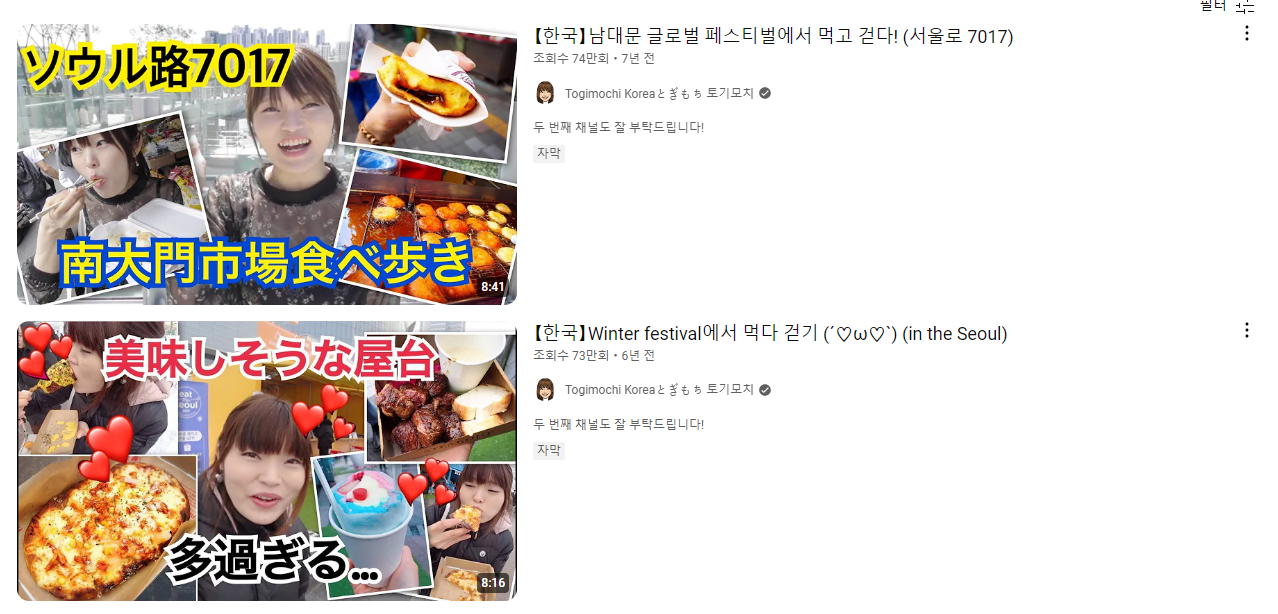

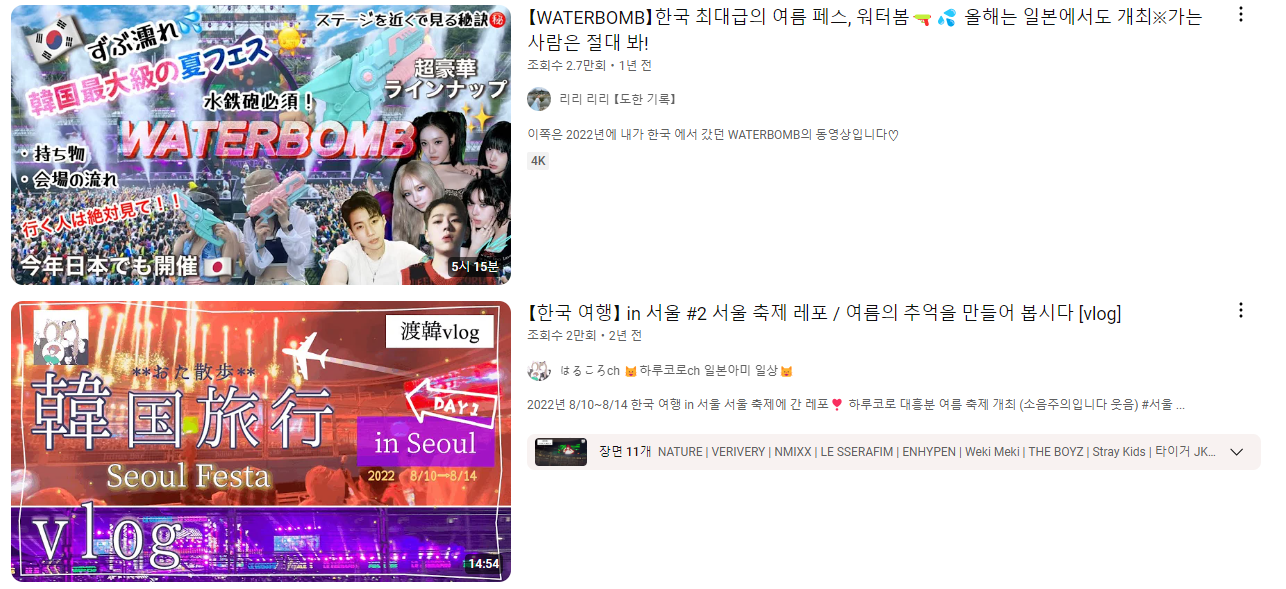

댓글과는 별개로 '한국 서울 festival' 로 검색했을 때 뜨는 영상을 조회수로 나열했을 때
- 조회수가 가장 높은 영상은 7년 전으로 최신화가 되어 있지 않음
- 그나마 조회수가 꽤 존재하는 영상의 경우도 1~2년 전이며 상대적으로 조회수가 낮아 축제에 대한 관심이 크게 없는 것으로 보임

- 유튜브 댓글 분석
    - 유의사항
        - 일본은 혐한 서적이 따로 존재할 만큼 넷 우익들이 많음
        - 유튜브 또한 혐한 콘텐츠 영상이 따로 존재한다

- 한국여행에 대해서는 대개로 긍정적인 편이다.
    - 영어에 대한 언급이 생각보다 많음
        - 데이터 살펴본 결과 한국에서 영어가 통하지 않는다고 생각하는 일본인이 다수
        - 아마, 일본인의 영어 발음과 한국인의 영어 발음 차이에서 생기는 문제라고 생각함
    - 바가지를 씌운다는 이미지가 꽤 있는 것으로 보임 (부정적 의견)
    - 화장실이 없음 (부정적 의견)

- 일본은 전통 축제 문화가 잘 발달해 있다
    - 한국의 축제와 일본의 축제를 비교하는 댓글의 내용이 많아서 일본 축제에 대한 특징이 워드 클라우드에서 잘 보여진다
    - 상대적으로 일본의 축제 문화가 있어서 일본인들은 한국 축제에 대한 관심이 크게 없는 것으로 보임
    - 한국의 전통성 없는 축제에 대해서 꽤 부정적 의견이 확인됨


1. 일본인이 한국의 전통 문화에 대해서 느낄 수 있는 축제가 따로 있을까?
2. 20대 일본인 여성(친구 동반) 이 즐길 수 있는 축제가 존재할까?

## 일본의 휴일?

- 일본은 4월 29일(쇼와의 날)을 시작으로 5월 초순까지 (5월 5~6일, 6일은 대체공휴일)
  황금연휴(골든위크) 기간이라고 해서 쉬는 기간이 존재
  - 물론 중간에 평일도 존재하지만 대다수의 일본인들은 휴무를 써서 이 기간 동안 여행을 많이 간다고 함

- EDA 분석 시 일본인들은 주로 한국 2박 3일로 머물고 있음
  - 일본 또한 주 5일 시행 국가이기에 한국에서 열리고 있는 축제 방문은 어렵지 않을 것으로 보임 (한국 축제는 대개로 주말에도 진행하기 때문)

## 20대 여자들이 좋아할 법한 축제

1. 서울 재즈 페스티벌
   + 매년 5월에 열림 (골든위크)
   + K-pop 콘텐츠와 여러 체험프로그램을 즐길 수 있음
   + 소셜미디어에 공유하기 좋음
   + 올림픽공원에서 열려 근처 여러 맛집들 순방 가능
   
2. 코리아뷰티페스티벌
   + 6월 내 운영  (내년에도 열릴지 모름)
   + 한국 화장품에 관심이 많은 여성에게 어필이 될 듯함
   + K-뷰티 체험, K-패션 체험 가능
   + 성수, 강남, 홍대, 명동에서 즐길 수 있음
   + 비슷한 행사) 서울뷰티위크(평일중에 열림..)
  
3. 부산 국제영화제
   + 10월 중순에 열림 (일본 공휴일 10월 14일 체육의 날이랑 겹치는 경우 존재)
   + K-콘텐츠(드라마 등)으로 접한 배우들을 볼 수 있음
   + 해운대, 광안리, 벡스코가 가까워 주변 관광지를 볼 수 있음

## 한국의 전통을 느낄 수 있는 축제

1. 삼척 정월대보름제
   + 일본 건국기념일(2월 11일) 전후로 열림(주말 포함)
   + 강원도 삼척에서 열림
   + 전통 민속놀이, 체험 프로그램, 제례 행사 등 한국의 전통을 느끼기 좋음
  
2. 화개장터 벚꽃축제
   + 벚꽃 피는 시즌에 열려 매번 다르나, 3월이나 4월 중에 열림, 일본 공휴일 춘분날(3월 20일)
   + 경남 하동 화개장터
   + 일본과 비슷하게 꽂놀이를 즐기면서도 한국의 장터 문화를 체험할 수 있음
   + 장터에서 먹을 수 있는 맛있는 먹거리
  
3. 진주 남강유등축제
   + 10월 초부터 10월 중순까지 하는 장기간 축제 (10월 14일 체육의 날과 겹침)
   + 한국 전통 등불과 떠다니는 유등을 통해 일본의 유등축제와의 차이와 전통문화를 느낄 수 있음
   + 진주성에서 열려 경복궁과는 다른 색다른 전통을 느낄 수 있음

4. 연등회
   + 25년 4월 2일 ~ 25년 5월 5일 (골든위크 기간과 겹침)
   + 국가무형유산
   + 한중일 중 유일하게 불교적 요소가 존재하는 연등회
       + https://www.beopbo.com/news/articleView.html?idxno=66979
   + 한국 전통의 불교 문화와 연등 행렬을 볼 수 있음
   + 조계사가 위치한 도심에서 축제가 진행되어 명동 등 주변 먹거리와 쇼핑을 즐길 수 있음